# VaR & CVaR through the Monte Carlo Simulation

### 🎲 Monte Carlo Simulation
Generates thousands of random future return scenarios to estimate the loss distribution, then derives:

- **VaR** → the α percentile of the simulated distribution  
- **CVaR** → the average loss beyond that quantile

<br>

### Why **Monte Carlo** instead of the **parametric** or **historical** approach?

Monte Carlo is **more flexible** because it doesn’t assume an oversimplified distribution like parametric models (often the normal distribution), and it’s **more powerful** than the historical approach, which only relies on past data.  
It allows simulating **an unlimited number of scenarios**, including rare or extreme events and complex correlations, providing a **more realistic and robust view of risk**.

<br>  

---

<br> 

### 📉 VaR (Value at Risk)
Measures the maximum expected loss on a portfolio for a given horizon and confidence level α.  
*Example: a 95% VaR = -3% means there is only a 5% chance that the loss will exceed -3%.*

$VaR_{α} = - \text{Quantile}_{α} (R)$

<br>

### 📉 CVaR (Conditional Value at Risk) or Expected Shortfall
Measures the average loss beyond the VaR, capturing the severity of the worst scenarios.

$CVaR_{α} = - \mathbb{E}[ R \mid R \leq -VaR_{α} ]$  

<br>

- **$R$** : distribution of simulated portfolio returns  
- **$Q_{α}(R)$** : quantile of the distribution at level **α** (e.g. α = 5% → the 5th percentile)  
- **$α$** : tolerated risk level (5% → we accept that 5% of losses will be worse than the VaR)  
- **$\mathbb{E}[\cdot]$** : mathematical expectation (the **mean** of the values)  
- **$R \mid R \leq -VaR_{α}$** : returns **less than or equal to** the VaR (the most unfavorable scenarios)  
- **$-VaR_{α}$** : loss threshold defined by the VaR, used as a limit to calculate the CVaR

<br>  

---

<br> 

### 🎲 Results
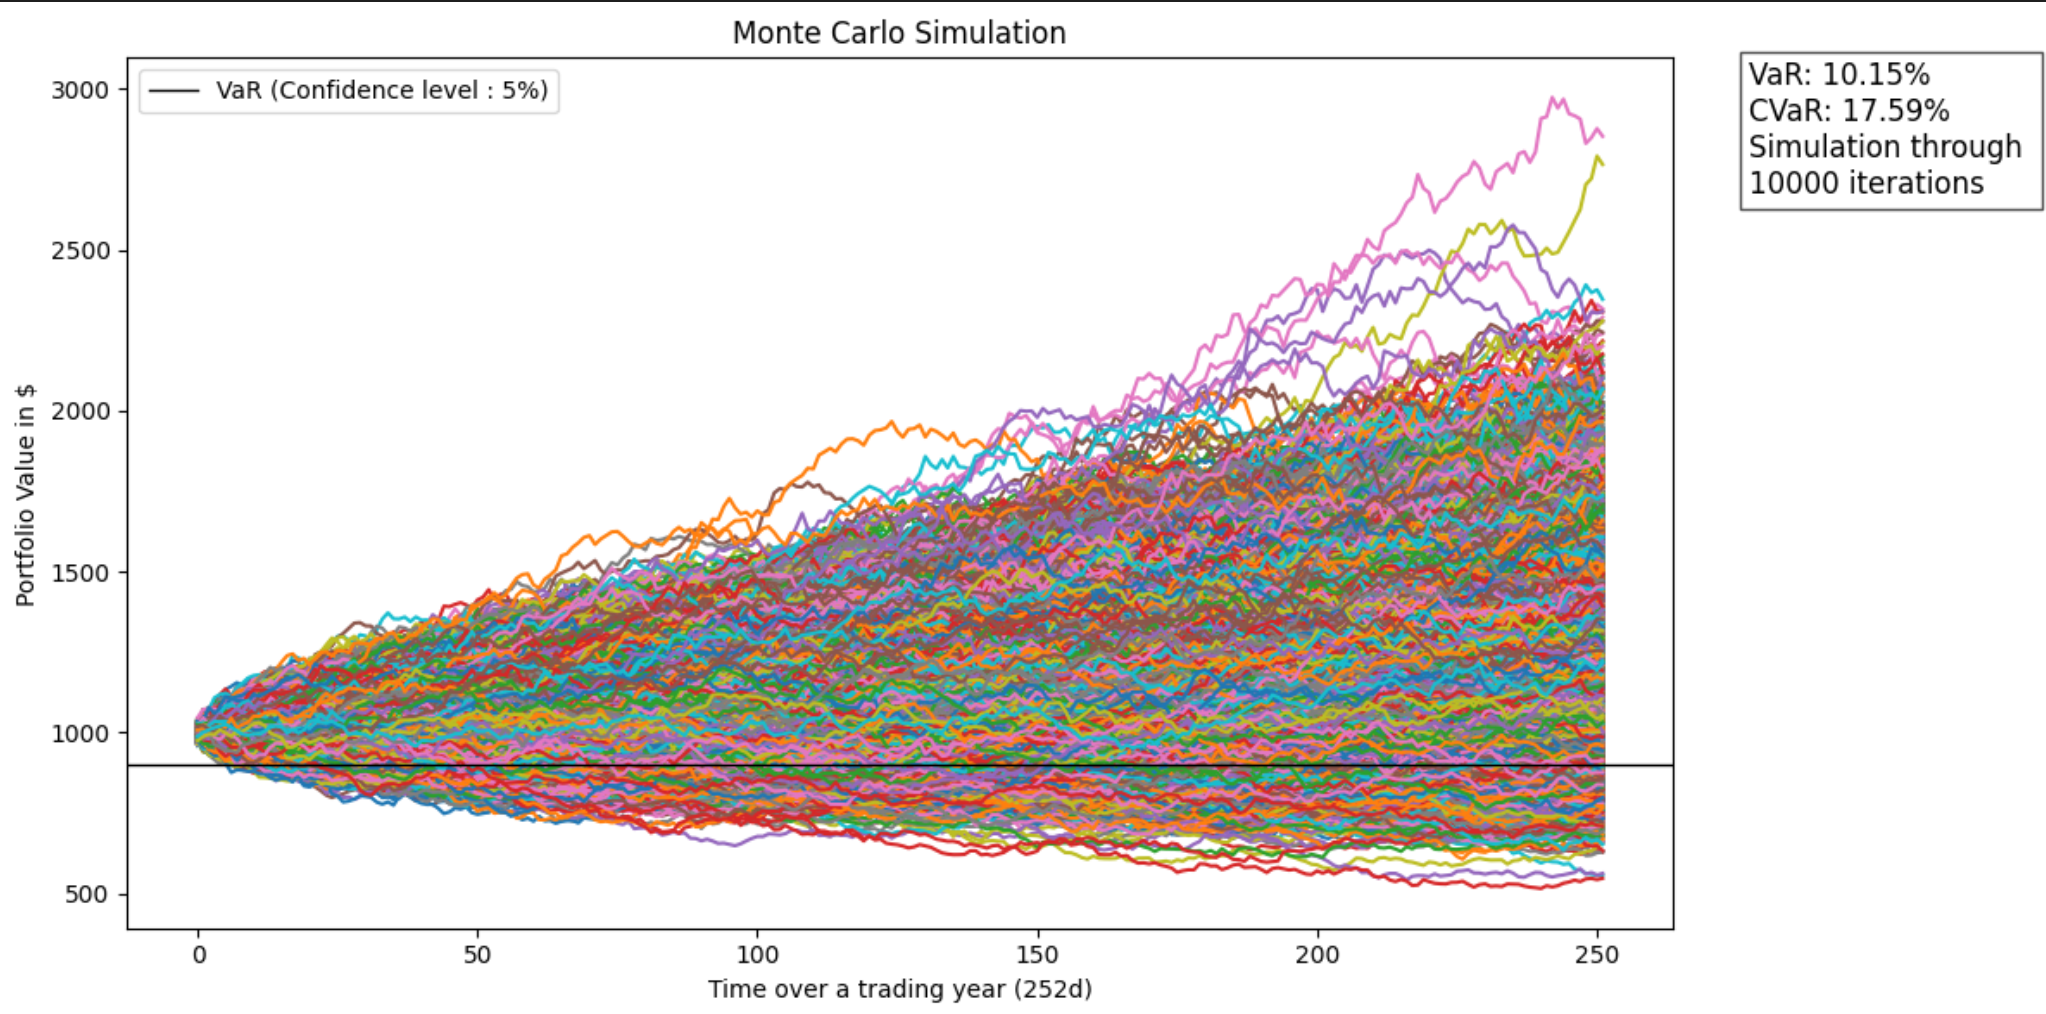

<br>


### The python script

C:\Users\Xtrai\AppData\Local\Temp\ipykernel_22676\1461717686.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(tickers, start, end)
[*********************100%***********************]  8 of 8 completed
C:\Users\Xtrai\AppData\Local\Temp\ipykernel_22676\1461717686.py:16: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = stock_data['Close'].pct_change().dropna()
C:\Users\Xtrai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


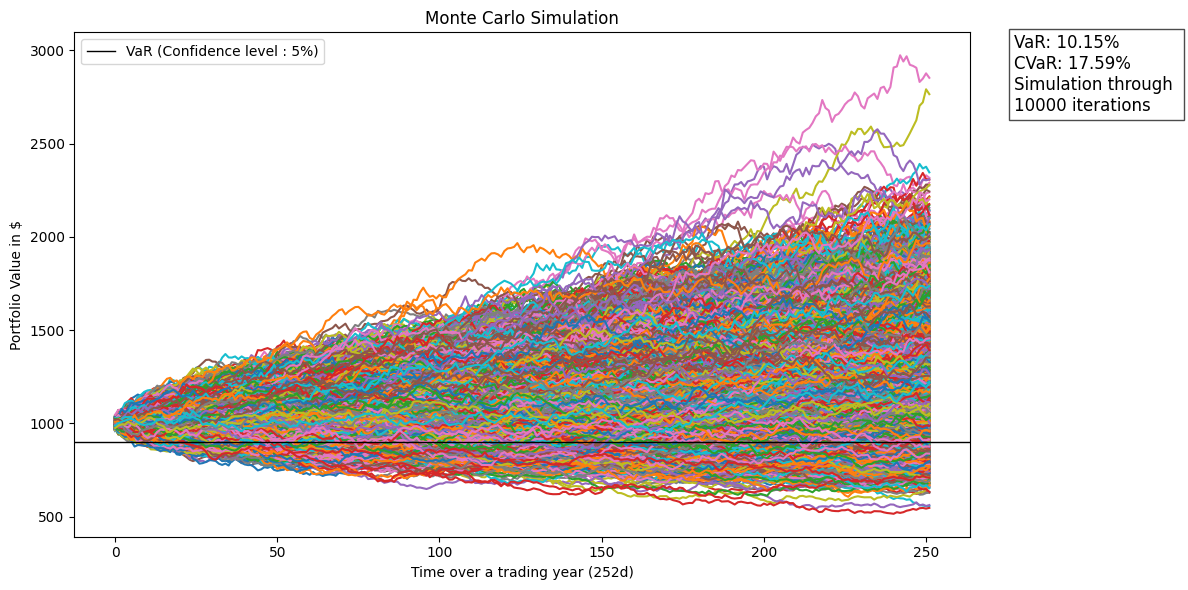

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from  datetime import datetime, timedelta


tickers = input("Enter your assets (ticker) separated by a comma as follows then press enter : SPY, GLD, BND, BTC-USD, ... :\n")
tickers = [t.strip() for t in tickers.split(',')]  # Convertit la chaîne d'entrée en liste [] d'actifs

end = datetime.today()
annees = int(input("Enter the number of years you want to consider (ex : 5) : "))
start = end - timedelta(annees * 365)

stock_data = yf.download(tickers, start, end)
returns = stock_data['Close'].pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()



weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)

returns['portfolio'] = returns @ weights                # ajout de la colomne portfolio (retours pondérés de chaque actifs)

expected_returns = np.sum(mean_returns * weights) * 252



# SIMULATION PART
time = 252
nb_sim = int(input('Enter the number of simulations desired (1000 to 100000) :'))

mean_returns_matrix = np.full(shape=(time, len(weights)), fill_value=mean_returns).T
portfolio_simulation = np.zeros(shape=(time, nb_sim))               # deuxieme matrice vide pleines de 0

for i in range(0, nb_sim):
    correlatedd_random_returns = np.random.multivariate_normal(mean_returns, cov_matrix, time)
    portfolio_simulation[:, i] = np.cumprod(np.inner(weights, correlatedd_random_returns) + 1) * 1000




# CALCULUS PART
def mcVaR(returns,alpha=5):
    if isinstance(returns, pd.Series):
        return np.percentile(returns,alpha)
    else:
        return TypeError('Expected a pandas data series')


def mcCVaR(returns,alpha=5):
    if isinstance(returns, pd.Series):
        below_var = returns <= mcVaR(returns, alpha=alpha)
        return returns[below_var].mean()
    else:
        return TypeError('Expected a pandas data series')


portfolio_results = pd.Series(portfolio_simulation[-1,:])

#portfolio_value = 1000
var = (1000 - mcVaR(portfolio_results, alpha=5)) / 1000 * 100
cvar = (1000 - mcCVaR(portfolio_results, alpha=5)) / 1000 * 100




# PLOTTING PART
plt.figure(figsize=(12, 6))
plt.plot(portfolio_simulation)
plt.title('Monte Carlo Simulation')
plt.xlabel('Time over a trading year (252d)')
plt.ylabel('Portfolio Value in $')

# Ajout de la VaR et CVaR sur le graphique
plt.text(x=len(portfolio_simulation)*1.1, y=portfolio_simulation.max()*0.9,
         s=f"VaR: {var:.2f}%\nCVaR: {cvar:.2f}%\nSimulation through \n{nb_sim} iterations",
         fontsize=12, bbox=dict(facecolor="white", alpha=0.7))
plt.tight_layout()

# Ajout de la ligne horizontale pour la VaR (5e percentile final)
plt.axhline(y=mcVaR(portfolio_results, alpha=5), color='black', linewidth=1, label='VaR (Confidence level : 5%)')
plt.legend()


plt.show()
